In [8]:
#this program is not complete
from zumi.zumi import Zumi
import matplotlib.pyplot as plt
import numpy as np
import time
import math

zumi = Zumi()
print(zumi.get_battery_voltage()," volts")

current_x = 0
current_y = 0

 Starting Zumi 
Pi Zero I2C is available
Verified Pi Zero is the same
Gyroscope previously calibrated
Zumi board detected
Compass detected
OLED Screen detected
Gyroscope & Accelerometer detected
1.1206896551724137  volts


In [11]:
def calc_heading_and_time_coordinate(desired_x,desired_y):
    global current_x, current_y

    y_intercept = 2.54
    slope = 15.24
    #slope is the speed Zumi 
    #travels at, in centimeters per second
    
    dx = desired_x - current_x
    dy = desired_y - current_y
    
    #find the angle
    angle = math.degrees(math.atan2(dy,dx)) 
    
    #find the distance to the coordinate
    distance = math.hypot(dy,dx)
    
    #calculate how much time in seconds 
    #it takes to travel the distance in centimeters
    duration = (distance + y_intercept)/slope
    
    #update the coordinates
    current_x = desired_x
    current_y = desired_y

    return distance, duration, angle

    
def move_cm_blocks(distance_cm,time_out,angle):
    # each white brick is 2cmx5cm 
    # we are traveling toward the 
    # brick from the 2cm length
    # from end of one white brick
    # to the end of another white brick
    # is roughly 4 cm
    cm_per_brick = 4
    #the amount of bricks you wish to cross over
    number_of_bricks = int(distance_cm/cm_per_brick)
    print(distance_cm)
    print(number_of_bricks)
    print(time_out)
    motor_speed = 40
    ir_threshold = 140
    zumi.turn(angle)

    init_time = time.time()

    #create list for the readings to be graphed
    time_list = []
    left_list = []
    right_list = []
    r_ir_list = []
    l_ir_list = []
    BRIR_list = []
    BLIR_list = []
    diff_lr= []
    
    #create variables for calculating derivative
    BLI_past = 0
    BRI_past = 0

    DBLI = 0
    DBRI = 0

    LBRICKS = 0
    RBRICKS = 0

    time_passed = 0
    time_first_brick = 0

    while(True):

        zumi.go_straight(40,angle)

        ir_readings = zumi.get_all_IR_data()
        bottom_right_ir = ir_readings[1]
        bottom_left_ir = ir_readings[3]

        #filter the bottom ir sensors
        if bottom_right_ir > 110:
            BRI = 1 # binary left ir  
        else:
            BRI = 0    
        if bottom_left_ir > 110:
            BLI = 1 # binary right ir   
        else:
            BLI = 0
        
    
        #change in right ir and left ir   
        DBRI = BLI - BLI_past
        DBLI = BRI - BRI_past
    
        if DBLI == -1:#falling edge or end of brick
            LBRICKS = LBRICKS + 1
        if DBRI == -1:#falling edge or end of brick
            RBRICKS = RBRICKS + 1

        #update past Binary Left IR (BLI) and Binary Right IR (BRI)
        BLI_past = BLI
        BRI_past = BRI
    
        time_passed = time.time()-init_time
    
        #measure the moment when the end of 
        #the first white brick has been detected
        if DBLI == -1 and LBRICKS ==1:
            time_first_brick = time_passed
            
        DIFF_LR = (bottom_left_ir-bottom_right_ir)/255
            
        #add data to lists
        BLIR_list.append(BLI)
        BRIR_list.append(BRI)
        time_list.append(time_passed)
        right_list.append(RBRICKS)
        left_list.append(LBRICKS)
        r_ir_list.append(bottom_right_ir)
        l_ir_list.append(bottom_left_ir)
        diff_lr.append(DIFF_LR)
        
        if time_passed > time_out:
            break
        if LBRICKS == number_of_bricks:
            break
        if RBRICKS == number_of_bricks:
            break       
    
    
    zumi.hard_brake()
    
    speed_cm_s = (LBRICKS-1)/(time_passed-time_first_brick)*cm_per_brick
    print(speed_cm_s, " cm/seconds ,",speed_cm_s/2.54, " inches/second")
    print("traveled ",LBRICKS*cm_per_brick, " cm ",LBRICKS*cm_per_brick/2.54, " cm ")
    print(len(time_list)," samples ,", time_passed," time passed")
    
    plt.plot(time_list,left_list,'ro',time_list,right_list,'bo')
    plt.ylabel('white bricks')
    plt.xlabel('time')
    plt.show()

    plt.plot(time_list,l_ir_list,'go',time_list,r_ir_list,'ro')
    plt.ylabel('ir values')
    plt.xlabel('time')
    plt.show()
    
    plt.plot(time_list,diff_lr,'go')
    plt.ylabel('ir diff')
    plt.xlabel('time')
    plt.show()


 Starting Zumi 
Pi Zero I2C is available
Verified Pi Zero is the same
Gyroscope previously calibrated
Zumi board detected
Compass detected
OLED Screen detected
Gyroscope & Accelerometer detected
Creating new offset file...
.
.
40.0
10
2.7913385826771653
8.948379072785915  cm/seconds , 3.5229838869235888  inches/second
traveled  28  cm  11.023622047244094  cm 
94  samples , 2.800916910171509  time passed


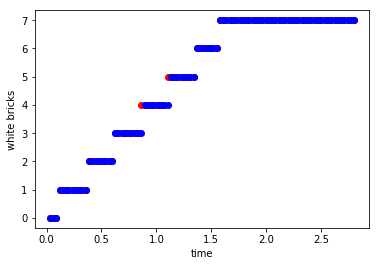

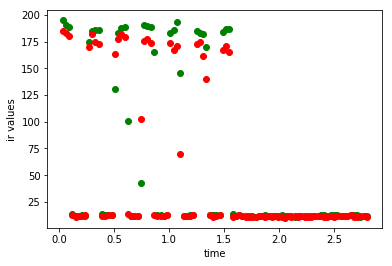

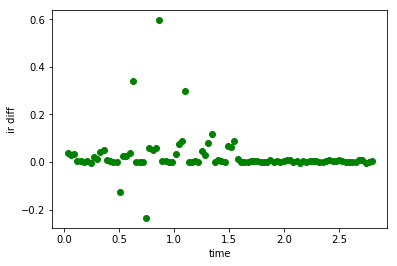

In [12]:

zumi = Zumi()
zumi.mpu.calibrate_MPU()
zumi.reset_gyro()


current_x = 0
current_y = 0

l_road = 42

distance, travel_time, angle = calc_heading_and_time_coordinate(4*10,0)
move_cm_blocks(distance,travel_time,angle)    
